In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU detectada:", gpus)
    except RuntimeError as e:
        print("Error en la configuración de GPU:", e)
else:
    print("No se detectó GPU. TensorFlow está usando CPU.")

2025-12-03 09:01:41.131554: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


✅ GPU detectada: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-12-03 09:01:43.515159: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2025-12-03 09:01:43.606474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: Tesla K20c computeCapability: 3.5
coreClock: 0.7055GHz coreCount: 13 deviceMemorySize: 4.63GiB deviceMemoryBandwidth: 193.71GiB/s
2025-12-03 09:01:43.607364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:06:00.0 name: Quadro K600 computeCapability: 3.0
coreClock: 0.8755GHz coreCount: 1 deviceMemorySize: 980.31MiB deviceMemoryBandwidth: 26.55GiB/s
2025-12-03 09:01:43.607415: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2025-12-03 09:01:43.665248: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2025-12-03 09:

In [2]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')

In [3]:
import os 
from pathlib import Path

path = Path('./DATASET2')

## Train
trainimgs = [str(path/'Train_images'/i) for i in os.listdir(path/'Train_images')]
trainmasks = [str(path/'Train_masks'/i) for i in os.listdir(path/'Train_masks')]
train_data = list(zip(trainimgs, trainmasks))

## Val
valimgs = [str(path/'Val_images'/i) for i in os.listdir(path/'Val_images')]
valmasks = [str(path/'Val_masks'/i) for i in os.listdir(path/'Val_masks')]
val_data = list(zip(valimgs, valmasks))

## Test
testimgs = [str(path/'Test_images'/i) for i in os.listdir(path/'Test_images')]
testmasks = [str(path/'Test_masks'/i) for i in os.listdir(path/'Test_masks')]
test_data = list(zip(testimgs, testmasks))

print(' - Train Set')
print('Número de imágenes en train:', len(trainimgs))
print('Número de máscaras en train:', len(trainmasks))
print()
print(' - Val Set')
print('Número de imágenes en val:', len(valimgs))
print('Número de máscaras en val:', len(valmasks))
print()
print(' - Test Set')
print('Número de imágenes en test:', len(testimgs))
print('Número de mascaras en test:', len(testmasks))
print()

 - Train Set
Número de imágenes en train: 11415
Número de máscaras en train: 11415

 - Val Set
Número de imágenes en val: 4077
Número de máscaras en val: 4077

 - Test Set
Número de imágenes en test: 816
Número de mascaras en test: 816



In [4]:
import tensorflow as tf
from tensorflow.keras import layers

# Fijar la semilla
tf.random.set_seed(123)

# Tamaños entrada y número de categorías
img_size = (256,256,3) # El tamaño de cada patch
nclases = 1

# ===============
# Entrada
entrada = tf.keras.Input(shape=img_size)

# ===============
# Codificador

# conv1
conv1 = layers.Conv2D(16,(3,3),activation='relu',padding='same')(entrada)
conv1 = layers.Conv2D(16,(3,3),activation='relu',padding='same')(conv1)
pool1 = layers.MaxPool2D((2,2))(conv1)

# conv2
conv2 = layers.Conv2D(32,(3,3),activation='relu',padding='same')(pool1)
conv2 = layers.Conv2D(32,(3,3),activation='relu',padding='same')(conv2)
pool2 = layers.MaxPool2D((2,2))(conv2)

# conv3
conv3 = layers.Conv2D(64,(3,3),activation='relu',padding='same')(pool2)
conv3 = layers.Conv2D(64,(3,3),activation='relu',padding='same')(conv3)
pool3 = layers.MaxPool2D((2,2))(conv3)

# conv4
conv4 = layers.Conv2D(128,(3,3),activation='relu',padding='same')(pool3)
conv4 = layers.Conv2D(128,(3,3),activation='relu',padding='same')(conv4)
pool4 = layers.MaxPool2D((2,2))(conv4)

# conv5
conv5 = layers.Conv2D(256,(3,3),activation='relu',padding='same')(pool4)
conv5 = layers.Conv2D(256,(3,3),activation='relu',padding='same')(conv5)

# ===============
# Decodificador

# dec1
dec1 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv5)
dec1 = layers.concatenate([dec1,conv4])
dec1 = layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same')(dec1)
dec1 = layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same')(dec1)

# dec2
dec2 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(dec1)
dec2 = layers.concatenate([dec2,conv3])
dec2 = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same')(dec2)
dec2 = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same')(dec2)

# dec3
dec3 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(dec2)
dec3 = layers.concatenate([dec3,conv2])
dec3 = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same')(dec3)
dec3 = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same')(dec3)

# dec4
dec4 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(dec3)
dec4 = layers.concatenate([dec4,conv1])
dec4 = layers.Conv2DTranspose(16, (3,3), activation='relu', padding='same')(dec4)
dec4 = layers.Conv2DTranspose(16, (3,3), activation='relu', padding='same')(dec4)

# ===============
# Salida
salida = layers.Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(dec4)
# ===============
# Interconectar todo en un modelo
unet = tf.keras.models.Model(inputs=entrada, outputs=salida)
unet.summary()

2025-12-03 09:01:44.630034: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2500035000 Hz
2025-12-03 09:01:44.630935: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x191f64d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-12-03 09:01:44.630976: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-12-03 09:01:44.787434: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x163d8c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-03 09:01:44.787461: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla K20c, Compute Capability 3.5
2025-12-03 09:01:44.789465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: Tesla K20c computeCapability: 3.5
coreClock: 0.7055GHz coreCount: 13 deviceMemorySize: 4

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [5]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [6]:
unet.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', dice_coef]
)

In [7]:
# Si las rutas están en formato Path, conviértelas a cadenas.
trainimgs = [str(img) for img in trainimgs]
trainmasks = [str(msk) for msk in trainmasks]
valimgs = [str(img) for img in valimgs]
valmasks = [str(msk) for msk in valmasks]
testimgs = [str(img) for img in testimgs]
testmasks = [str(msk) for msk in testmasks]

trainimgs, trainmasks = zip(*train_data)
valimgs, valmasks = zip(*val_data)
testimgs, testmasks = zip(*test_data)

trainimgs = list(trainimgs)
trainmasks = list(trainmasks)
valimgs = list(valimgs)
valmasks = list(valmasks)
testimgs = list(testimgs)
testmasks = list(testmasks)

In [8]:
# Ahora crea los datasets como lo mencionamos antes
ds_train = tf.data.Dataset.from_tensor_slices((trainimgs, trainmasks))
ds_train = ds_train.shuffle(buffer_size=1000).batch(32)

ds_val = tf.data.Dataset.from_tensor_slices((valimgs, valmasks))
ds_val = ds_val.batch(32)

ds_test = tf.data.Dataset.from_tensor_slices((testimgs, testmasks))
ds_test = ds_test.batch(32)

import tensorflow as tf
from pathlib import Path

# Fijar directorios para las imágenes y las máscaras
DIR_IMGS = Path('./DATASET/Train_images/')
DIR_MSKS = Path('./DATASET/Train_mask/')


In [9]:
# La función para lectura y pre-procesamiento
def preprocesar_imagen(imgpath, mskpath):
    # Crear rutas completas a partir de las rutas relativas
    # Leer las imágenes y las máscaras como archivos
    img = tf.io.read_file(imgpath)  # Ahora imgpath es una cadena
    msk = tf.io.read_file(mskpath)  # Ahora mskpath es una cadena

    img = tf.image.decode_jpeg(img, channels=3)  # uint8
    msk = tf.image.decode_png(msk, channels=1)   # uint8

    img = tf.image.convert_image_dtype(img, dtype=tf.float32) 

    msk = tf.image.convert_image_dtype(msk, dtype=tf.float32)

    return img, msk

In [10]:
# Aplicar preprocesamiento y crear los lotes
ds_train = tf.data.Dataset.from_tensor_slices((trainimgs, trainmasks))
ds_train = ds_train.map(lambda img, msk: preprocesar_imagen(img, msk))  # Mapeamos el preprocesamiento
ds_train = ds_train.shuffle(buffer_size=1000).batch(32)

ds_val = tf.data.Dataset.from_tensor_slices((valimgs, valmasks))
ds_val = ds_val.map(lambda img, msk: preprocesar_imagen(img, msk))  # Mapeamos el preprocesamiento
ds_val = ds_val.batch(32)

ds_test = tf.data.Dataset.from_tensor_slices((testimgs, testmasks))
ds_test = ds_test.map(lambda img, msk: preprocesar_imagen(img, msk))  # Mapeamos el preprocesamiento
ds_test = ds_test.batch(32)

In [11]:
# Y entrenar el modelo: ¡en este punto SÍ se leen las imágenes!
print ("Comenzando entrenamiento")

history = unet.fit(ds_train, validation_data = ds_val, epochs=200, verbose=2)

print ("Entrenamiento finalizado con éxito")

Comenzando entrenamiento
Epoch 1/200


2025-12-03 09:01:58.009015: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2025-12-03 09:01:59.727679: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2025-12-03 09:01:59.783935: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-12-03 09:02:00.615364: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2025-12-03 09:02:16.373378: W tensorflow/core/common_runtime/bfc_allocator.cc:246] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


357/357 - 451s - loss: 0.1500 - accuracy: 0.9393 - dice_coef: 0.7079 - val_loss: 0.1260 - val_accuracy: 0.9567 - val_dice_coef: 0.7874
Epoch 2/200
357/357 - 338s - loss: 0.0715 - accuracy: 0.9765 - dice_coef: 0.8692 - val_loss: 0.0690 - val_accuracy: 0.9787 - val_dice_coef: 0.9151
Epoch 3/200
357/357 - 335s - loss: 0.0553 - accuracy: 0.9816 - dice_coef: 0.9007 - val_loss: 0.0483 - val_accuracy: 0.9837 - val_dice_coef: 0.9158
Epoch 4/200
357/357 - 334s - loss: 0.0501 - accuracy: 0.9833 - dice_coef: 0.9097 - val_loss: 0.0481 - val_accuracy: 0.9837 - val_dice_coef: 0.9229
Epoch 5/200
357/357 - 334s - loss: 0.0465 - accuracy: 0.9845 - dice_coef: 0.9168 - val_loss: 0.0458 - val_accuracy: 0.9844 - val_dice_coef: 0.9284
Epoch 6/200
357/357 - 335s - loss: 0.0454 - accuracy: 0.9852 - dice_coef: 0.9209 - val_loss: 0.0434 - val_accuracy: 0.9851 - val_dice_coef: 0.9309
Epoch 7/200
357/357 - 336s - loss: 0.0406 - accuracy: 0.9864 - dice_coef: 0.9273 - val_loss: 0.0395 - val_accuracy: 0.9860 - val_d

## Guardado de modelo

In [12]:
unet.save(('Modelo_Final.keras'))

## Prueba del modelo

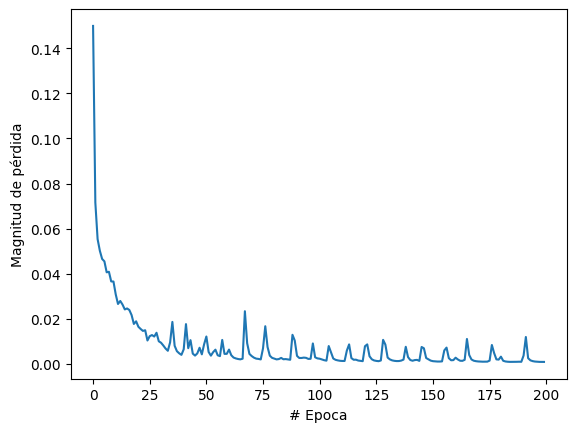

In [13]:
import matplotlib.pyplot as plt
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(history.history["loss"])

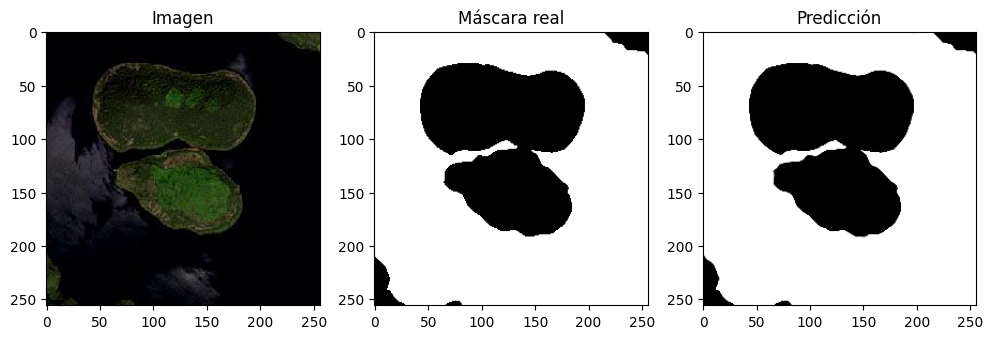

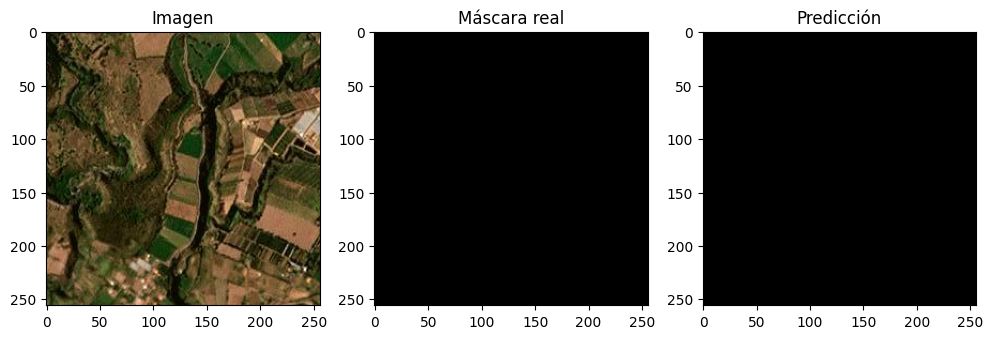

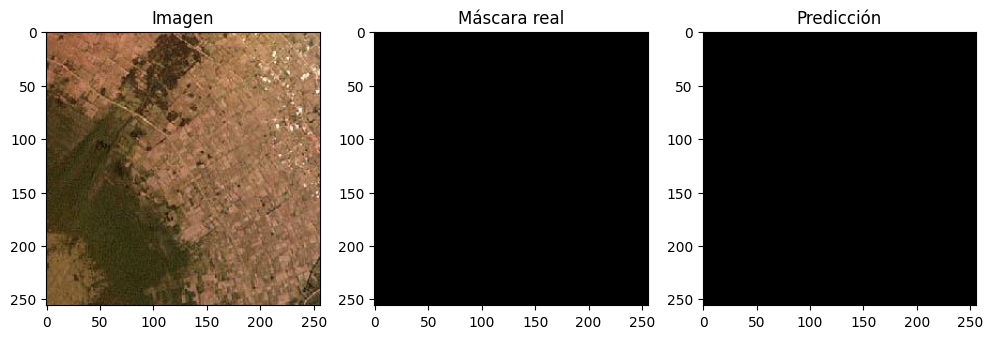

In [14]:
import matplotlib.pyplot as plt

# Obtener una imagen del dataset de validación
for img, msk in ds_val.take(1):
    pred = unet.predict(img)

    for i in range(3):  # Mostrar 3 ejemplos
        plt.figure(figsize=(12,4))
        
        plt.subplot(1,3,1)
        plt.title("Imagen")
        plt.imshow(img[i])
        
        plt.subplot(1,3,2)
        plt.title("Máscara real")
        plt.imshow(msk[i,...,0], cmap='gray')
        
        plt.subplot(1,3,3)
        plt.title("Predicción")
        plt.imshow(pred[i,...,0], cmap='gray')
        
        plt.show()
